In [1]:
import os
import glob
import numpy as np
import cv2

In [38]:
from utils.xyz import gamma, positional_encoder
import torch 
import warnings


In [39]:
vec = torch.rand(10,5) + 2
px, pd = positional_encoder(vec, Lx=10, Ld=4)


/home/ubuntu/NeRF_CT/utils/xyz.py:9: UserWarning: input not in range -1,1, check rescaling
  warnings.warn("input not in range -1,1, check rescaling")


In [3]:
from utils.dataload import load_data
data, cam_params = load_data('data/nerf_synthetic/lego/')

[800, 800, 1111.1110311937682]


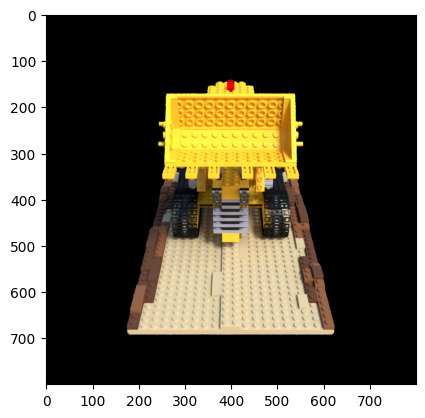

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.imshow(data['test'][50]['img'])

print(cam_params)

In [14]:
np.max(data['train'][0]['img'])


255